# Import Libraries

In [1]:
import os
import gc

import pandas as pd
import numpy as np
import warnings

# %pip install polars==0.16.9
import polars as pl
import pyarrow as pa

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import f1_score

from xgboost import XGBClassifier

# Import Datasets
Import the datasets using **polars**

In [2]:
df_train = pl.read_csv("data/train.csv")
df_train_labels = pd.read_csv("data/train_labels.csv")

df_test = (
    pl.read_csv("data/test.csv")
    .drop("session_level")
)

# Seperate `session`and `q` in **df_train_labels**

In [3]:
df_train_labels['session'] = df_train_labels.session_id.apply(lambda x: int(x.split('_')[0]))
df_train_labels['q'] = df_train_labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
df_train_labels.head(5)

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


# Drop Columns
Drop `fullscreen`, `hq` and `music` since they contain only missing values

In [4]:
drop_col = ["fullscreen", "hq", "music"]

df_train = df_train.drop(drop_col)
df_test = df_test.drop(drop_col)

# Select Columns
## Numerical and categorical features

In [5]:
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration', 'elapsed_time_diff']
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']

## `name` and `event_name`

In [6]:
# name - the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)
name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']

# the name of the event type
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click', 'observation_click', 'notification_click',  'object_click', 'object_hover', 'map_hover', 'map_click', 'checkpoint', 'notebook_click']

## `fqid`, `text` and `room`

In [7]:
# from https://www.kaggle.com/code/leehomhuang/catboost-baseline-with-lots-features-inference :
#fqid - the fully qualified ID of the event
fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']

#the fully qualified ID of the
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']

#room_fqid - the fully qualified ID of the room the event took place in
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

# Define New Columns
Using list of Polars column expressions

In [8]:
columns = [
    # Convert the "page" column to a float32 data type.
    pl.col("page").cast(pl.Float32),
    
    # Calculate the difference between the current row's "elapsed_time" and the previous row's "elapsed_time",
    # replace null values with zeros, limit values to be within the range of 0 and 1 billion,
    # and perform the computation over windows defined by the "session_id" and "level_group" columns.
    # Give the resulting column a new name "elapsed_time_diff".
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) 
         .fill_null(0)
         .clip(0, 1e9)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    
    # Calculate the absolute difference between the current row's "screen_coor_x" and the previous row's "screen_coor_x",
    # and perform the computation over windows defined by the "session_id" and "level_group" columns.
    # Give the resulting column a new name "location_x_diff".
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) 
         .abs()
         .over(["session_id", "level_group"])
        .alias("location_x_diff") 
    ),
    
    # Calculate the absolute difference between the current row's "screen_coor_y" and the previous row's "screen_coor_y",
    # and perform the computation over windows defined by the "session_id" and "level_group" columns.
    # Give the resulting column a new name "location_y_diff".
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) 
         .abs()
         .over(["session_id", "level_group"])
        .alias("location_y_diff") 
    ),
    
    # Replace null values in the "fqid" column with the string "fqid_None".
    pl.col("fqid").fill_null("fqid_None"),
    
    # Replace null values in the "text_fqid" column with the string "text_fqid_None".
    pl.col("text_fqid").fill_null("text_fqid_None")
]

In [9]:
df_train = df_train.with_columns(columns)

# Feature Engineering
Aggregate the log data by `session_id` level

In [10]:
def feature_engineer_pl(x, grp, use_extra, feature_suffix):
    aggs = [
        # counting the number of non-null values in a column named "index" 
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),
    
        # removes any rows that have null values -  computes the number of unique values in the remaining rows of the selected column.
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],

        # Let's say we have the following list of numbers: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        # Using the "nearest" method, we take the value at index 2, which is 30. Therefore, the 20th percentile value using the "nearest" method for this list of numbers is 30.
        [pl.col(c).quantile(0.1, "nearest").alias(f"{c}_quantile1_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.2, "nearest").alias(f"{c}_quantile2_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.4, "nearest").alias(f"{c}_quantile4_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.6, "nearest").alias(f"{c}_quantile6_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.8, "nearest").alias(f"{c}_quantile8_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.9, "nearest").alias(f"{c}_quantile9_{feature_suffix}") for c in NUMS],
        
        # Calculate mean, std, min, max
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        
        # Calculate percentile, mean, std, max, min for event_name_feature
        *[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}")for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).quantile(0.1, "nearest").alias(f"{c}_ET_quantile1_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).quantile(0.2, "nearest").alias(f"{c}_ET_quantile2_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).quantile(0.4, "nearest").alias(f"{c}_ET_quantile4_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).quantile(0.6, "nearest").alias(f"{c}_ET_quantile6_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).quantile(0.8, "nearest").alias(f"{c}_ET_quantile8_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).quantile(0.9, "nearest").alias(f"{c}_ET_quantile9_{feature_suffix}") for c in event_name_feature],      
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in event_name_feature],

        # Calculate elapsed time diff mean, max, min, std for name_feature
        *[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}")for c in name_feature],   
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in name_feature],  
        
        # Calculate elapsed time diff mean, max, min, std for room_lists
        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}")for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in room_lists],
        
        # Calculate elapsed time diff mean, max, min, std for fqid_lists
        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}")for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in fqid_lists],
       
        # Calculate elapsed time diff mean, max, min, std for text_lists
        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in text_lists],
        
        # Calculate location_x_diff mean, max, min, std for event_name_feature
        *[pl.col("location_x_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_x{feature_suffix}") for c in event_name_feature],
        *[pl.col("location_x_diff").filter(pl.col("event_name")==c).std().alias(f"{c}_ET_std_x{feature_suffix}") for c in event_name_feature],
        *[pl.col("location_x_diff").filter(pl.col("event_name")==c).max().alias(f"{c}_ET_max_x{feature_suffix}") for c in event_name_feature],
        *[pl.col("location_x_diff").filter(pl.col("event_name")==c).min().alias(f"{c}_ET_min_x{feature_suffix}") for c in event_name_feature],
    ]
    
    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
  
    if use_extra:
        if grp=='5-12':
            aggs = [
                # Analysis of event logs to understand user behavior and performance within an application.
                # Calculate Duration and count Index
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp=='13-22':
            aggs = [
                # Calculate Duration and count Index
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')
        
    return df.to_pandas()

## Separately perfrom by `level_group`

In [11]:
df_train_1 = df_train.filter(pl.col("level_group")=='0-4')
df_train_2 = df_train.filter(pl.col("level_group")=='5-12')
df_train_3 = df_train.filter(pl.col("level_group")=='13-22')

print("Shape of df_train_1:", df_train_1.shape)
print("Shape of df_train_2:", df_train_2.shape)
print("Shape of df_train_2:", df_train_3.shape)

Shape of df_train_1: (1994687, 20)
Shape of df_train_2: (4433127, 20)
Shape of df_train_2: (6746397, 20)


In [12]:
del df_train
gc.collect()

0

In [13]:
df_train_1 = feature_engineer_pl(df_train_1, grp = "0-4", use_extra = True, feature_suffix = "")
df_train_2 = feature_engineer_pl(df_train_2, grp = "0-4", use_extra = True, feature_suffix = "")
df_train_3 = feature_engineer_pl(df_train_3, grp = "0-4", use_extra = True, feature_suffix = "")

print("df_train_1 done; Shape of df_train_1:", df_train_1.shape)
print("df_train_2 done; Shape of df_train_2:", df_train_2.shape)
print("df_train_3 done; Shape of df_train_2:", df_train_3.shape)

df_train_1 done; Shape of df_train_1: (11779, 1898)
df_train_2 done; Shape of df_train_2: (11779, 1898)
df_train_3 done; Shape of df_train_2: (11779, 1898)


# Cleaing
Drop columns that have a high percentage of missing values > 0.9

In [14]:
null1 = df_train_1.isnull().sum().sort_values(ascending=False) / len(df_train_1)
null2 = df_train_2.isnull().sum().sort_values(ascending=False) / len(df_train_2)
null3 = df_train_3.isnull().sum().sort_values(ascending=False) / len(df_train_3)

drop1 = list(null1[null1>0.9].index)
drop2 = list(null2[null2>0.9].index)
drop3 = list(null3[null3>0.9].index)

print("Number of columns drop in df_train_1:", len(drop1))
print("Number of columns drop in df_train_2:", len(drop2))
print("Number of columns drop in df_train_3:", len(drop3))

Number of columns drop in df_train_1: 1088
Number of columns drop in df_train_2: 830
Number of columns drop in df_train_3: 726


Check columns that have a single unique value across all rows and drops those columns as well.

In [15]:
for col in df_train_1.columns:
    if df_train_1[col].nunique()==1:
        drop1.append(col)

for col in df_train_2.columns:
    if df_train_2[col].nunique()==1:
        drop2.append(col)

for col in df_train_3.columns:
    if df_train_3[col].nunique()==1:
        drop3.append(col)

print("Number of columns drop in df_train_1:", len(drop1))
print("Number of columns drop in df_train_2:", len(drop2))
print("Number of columns drop in df_train_3:", len(drop3))

Number of columns drop in df_train_1: 1299
Number of columns drop in df_train_2: 986
Number of columns drop in df_train_3: 840


# Set Index

In [16]:
df_train_1 = df_train_1.set_index('session_id')
df_train_2 = df_train_2.set_index('session_id')
df_train_3 = df_train_3.set_index('session_id')

FEATURES1 = [c for c in df_train_1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df_train_2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df_train_1.columns if c not in drop3+['level_group']]

print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df_train_1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 599 914 1059 features
We will train with 11779 users info


# Create XGB Decison Tree Model

## 5 group K-fold cross-validation

In [17]:
xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'use_label_encoder' : False
}

In [18]:
warnings.filterwarnings("ignore")
gkf = GroupKFold(n_splits = 5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS), 18)), index = ALL_USERS)
models = {}

for grp in range(1, 4):
    if grp == 1:
        df = df_train_1
        qrange = range(1, 5)
        FEATURES = FEATURES1
        print("Group 0-4")
    
    elif grp == 2:
        df = df_train_2
        qrange = range(5, 13)
        FEATURES = FEATURES2
        print("Group 5-12")
    
    elif grp == 3:
        df = df_train_3
        qrange = range(13, 19)
        FEATURES = FEATURES3
        print("Group 13-18")

    for i, (train_index, test_index) in enumerate(gkf.split(X = df, groups = df.index)):
        best_score = 0
        best_threshold = 0
        
        print('#'*25)
        print('### Fold',i+1)
        print('#'*25)
        
        for t in qrange:                
            # TRAIN DATA
            train_x = df.iloc[train_index]
            # train_x = train_x.loc[train_x.level_group == grp]
            train_users = train_x.index.values
            train_y = df_train_labels.loc[df_train_labels.q==t].set_index('session').loc[train_users]
            
            # VALID DATA
            valid_x = df.iloc[test_index]
            # valid_x = valid_x.loc[valid_x.level_group == grp]
            valid_users = valid_x.index.values
            valid_y = df_train_labels.loc[df_train_labels.q==t].set_index('session').loc[valid_users]
            
            # TRAIN MODEL        
            clf =  XGBClassifier(**xgb_params)
            clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                    eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                    verbose=0)
            print(f'{t}({clf.best_ntree_limit}), ',end='')
            
            # SAVE MODEL, PREDICT VALID OOF
            models[f'{t}_{i}'] = clf
            oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
            
        print()
    
    print("\n")

Group 0-4
#########################
### Fold 1
#########################
1(207), 2(121), 3(97), 4(116), 
#########################
### Fold 2
#########################
1(130), 2(113), 3(114), 4(135), 
#########################
### Fold 3
#########################
1(131), 2(133), 3(120), 4(112), 
#########################
### Fold 4
#########################
1(146), 2(123), 3(112), 4(110), 
#########################
### Fold 5
#########################
1(197), 2(107), 3(124), 4(107), 


Group 5-12
#########################
### Fold 1
#########################
5(194), 6(166), 7(215), 8(79), 9(85), 10(140), 11(117), 12(122), 
#########################
### Fold 2
#########################
5(167), 6(125), 7(124), 8(47), 9(120), 10(121), 11(114), 12(76), 
#########################
### Fold 3
#########################
5(102), 6(117), 7(245), 8(66), 9(141), 10(123), 11(83), 12(73), 
#########################
### Fold 4
#########################
5(285), 6(109), 7(122), 8(38), 9(92), 10(111), 11

## Compute CV Score
Predict `correct` by setting a threshold such that *p > threshold* then 1 elso 0, then maximize the f1 score

In [19]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = pd.DataFrame(data=np.zeros((len(ALL_USERS), 18)), index = ALL_USERS)
for k in range(18):
    # GET TRUE LABELS
    tmp = df_train_labels.loc[df_train_labels.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [20]:
thresholds = np.arange(0.4,0.81,0.01)
score = np.zeros((18, 5, len(thresholds)))

for q in range(1, 19):
    if q <= 4: X = df_train_1[FEATURES1].astype("float32")
    elif q <= 12: X = df_train_2[FEATURES2].astype("float32")
    else: X = df_train_3[FEATURES3].astype("float32")
    
    true = df_train_labels[df_train_labels["q"] == q].set_index("session").loc[X.index]["correct"]
    
    for fold in range(5):
        # print(f"{q}_{fold}")
        clf = models[f"{q}_{fold}"]
        pred = clf.predict_proba(X)[:, 1]
        
        for t in range(len(thresholds)):
            threshold = thresholds[t]
            pred_t = (pred > threshold).astype("int")
            score[q-1, fold, t] = f1_score(true, pred_t)

## Plot f1 score against threshold

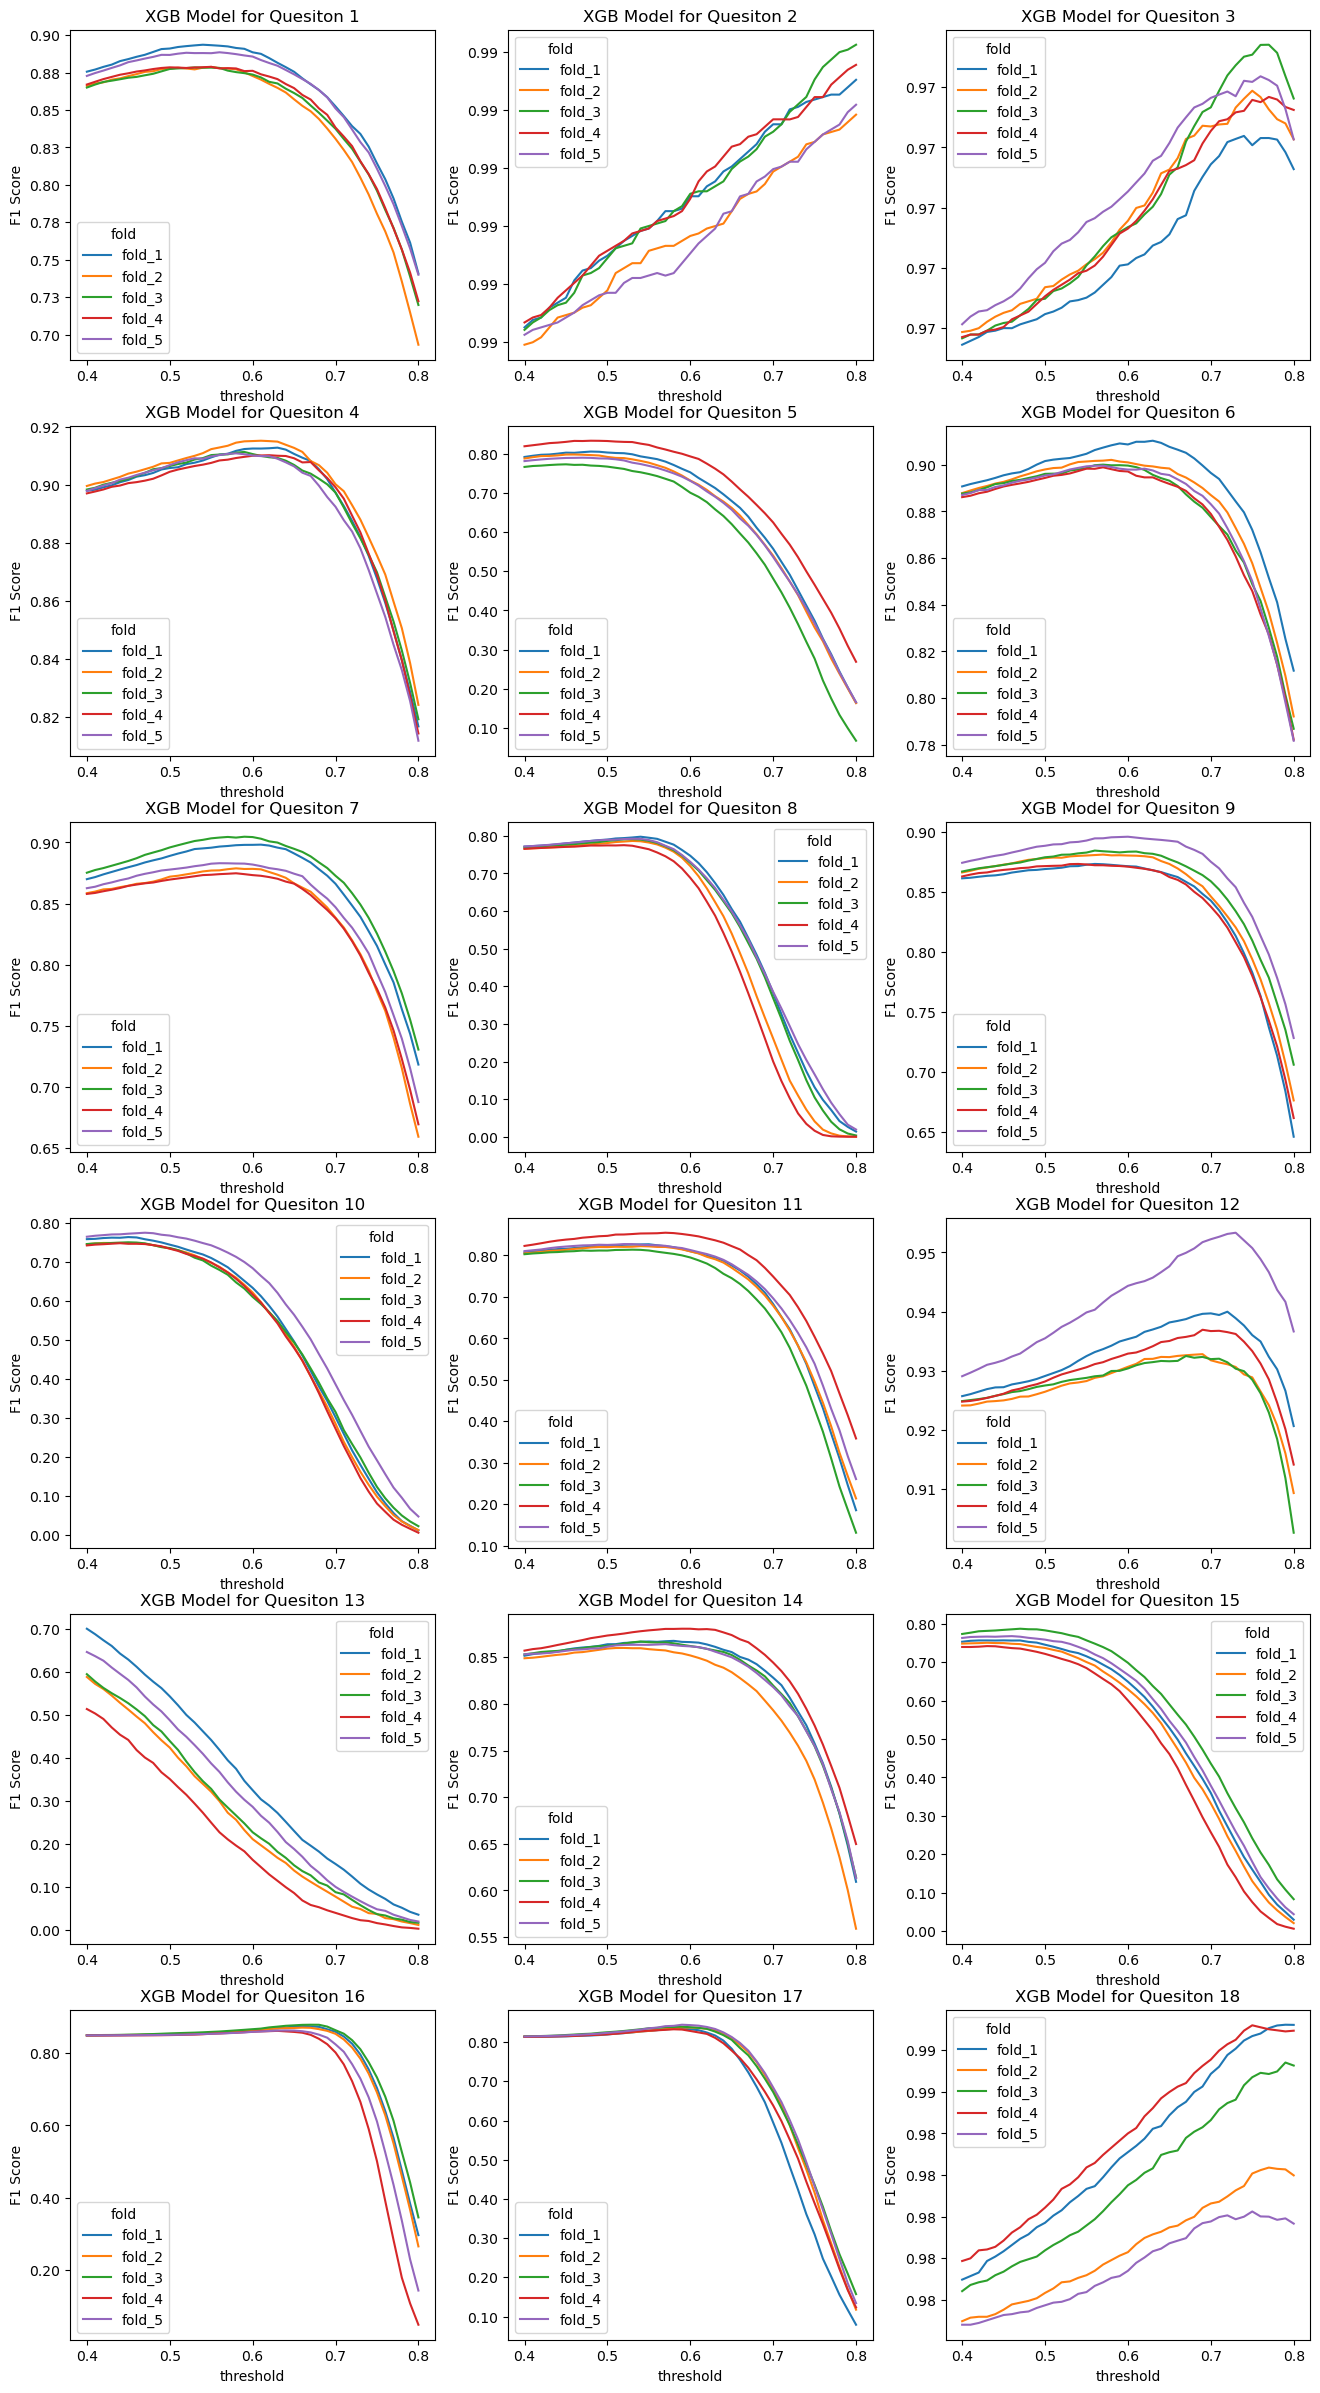

In [21]:
plt.figure(figsize = (16, 30))
folds = [f"fold_{i}" for i in range(1, 6)]

for q in range(18):
    df = pd.DataFrame(score[q, :, :].transpose(), columns = folds)
    df["threshold"] = thresholds
    df = df.melt(id_vars = "threshold", value_vars = folds, var_name = "fold")
    
    plt.subplot(6, 3, q+1)
    sns.lineplot(df, x = "threshold", y = "value", hue = "fold")
    plt.ylabel("F1 Score")
    plt.title(f"XGB Model for Quesiton {q+1}")
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

plt.savefig("model_plot/f1_threshold.pdf", format = "pdf", bbox_inches = "tight")
plt.show()

## The best model and threshold of each question

In [22]:
best_scores = score.max(axis = 2)
best_folds = best_scores.argmax(axis = 1)
best_folds

array([0, 2, 2, 1, 3, 0, 2, 0, 4, 4, 3, 4, 0, 3, 2, 2, 4, 0])

In [23]:
best_scores = score.max(axis = 1)
best_thresholds = best_scores.argmax(axis = 1)
best_thresholds
np.array([np.round(thresholds[t], 2) for t in best_thresholds])

array([0.54, 0.8 , 0.77, 0.61, 0.48, 0.63, 0.59, 0.54, 0.6 , 0.47, 0.57,
       0.73, 0.4 , 0.59, 0.47, 0.67, 0.59, 0.79])

## Using optimal threshold for all questions

In [37]:
from tabulate import tabulate
best_scores = score.max(axis = 2)
print(tabulate(best_scores, tablefmt = "latex", floatfmt = ".4f"))

\begin{tabular}{rrrrr}
\hline
 0.8936 & 0.8788 & 0.8785 & 0.8789 & 0.8886 \\
 0.9945 & 0.9939 & 0.9951 & 0.9948 & 0.9941 \\
 0.9724 & 0.9739 & 0.9754 & 0.9737 & 0.9744 \\
 0.9129 & 0.9153 & 0.9114 & 0.9103 & 0.9109 \\
 0.8065 & 0.7989 & 0.7738 & 0.8342 & 0.7908 \\
 0.9103 & 0.9021 & 0.9001 & 0.8989 & 0.8996 \\
 0.8982 & 0.8788 & 0.9047 & 0.8748 & 0.8830 \\
 0.7978 & 0.7865 & 0.7913 & 0.7753 & 0.7923 \\
 0.8733 & 0.8811 & 0.8844 & 0.8733 & 0.8960 \\
 0.7635 & 0.7485 & 0.7501 & 0.7478 & 0.7747 \\
 0.8270 & 0.8225 & 0.8140 & 0.8548 & 0.8274 \\
 0.9400 & 0.9328 & 0.9325 & 0.9369 & 0.9533 \\
 0.7009 & 0.5888 & 0.5952 & 0.5141 & 0.6468 \\
 0.8676 & 0.8600 & 0.8669 & 0.8806 & 0.8641 \\
 0.7568 & 0.7506 & 0.7871 & 0.7419 & 0.7678 \\
 0.8751 & 0.8708 & 0.8789 & 0.8619 & 0.8631 \\
 0.8346 & 0.8374 & 0.8395 & 0.8328 & 0.8445 \\
 0.9892 & 0.9824 & 0.9874 & 0.9892 & 0.9802 \\
\hline
\end{tabular}


In [24]:
y_pred_all = np.array([])

for q in range(1, 19):
    if q <= 4: X = df_train_1[FEATURES1].astype("float32")
    elif q <= 12: X = df_train_2[FEATURES2].astype("float32")
    else: X = df_train_3[FEATURES3].astype("float32")
    
    fold = best_folds[q-1]
    threshold = thresholds[best_thresholds[q-1]]
    
    clf = models[f"{q}_{fold}"]
    pred = clf.predict_proba(X)[:, 1]
    pred_t = (pred > threshold).astype("int")
    y_pred_all = np.append(y_pred_all, pred_t)
    
    true = df_train_labels[df_train_labels["q"] == q].set_index("session").loc[X.index]["correct"]
    f1 = f1_score(true, pred_t)
    
    print(f"Q{q}: F1 = {f1}")

Q1: F1 = 0.8936499171728326
Q2: F1 = 0.9951206874217368
Q3: F1 = 0.9754131398629584
Q4: F1 = 0.9152984887282222
Q5: F1 = 0.8342291980219307
Q6: F1 = 0.910334666386024
Q7: F1 = 0.9046664439247132
Q8: F1 = 0.7977892586807642
Q9: F1 = 0.895967653808327
Q10: F1 = 0.7746889878666872
Q11: F1 = 0.8548407090616091
Q12: F1 = 0.9533352696291993
Q13: F1 = 0.7008944543828265
Q14: F1 = 0.8806213767096303
Q15: F1 = 0.7871311078858247
Q16: F1 = 0.8788753474449433
Q17: F1 = 0.8444517113581862
Q18: F1 = 0.989228245932887


## Overall f1 score

In [25]:
f1_score(df_train_labels["correct"], y_pred_all)

0.8930462923520024